In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from ipywidgets import interact
%matplotlib inline

In [2]:
# data files are from http://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.html
# (see also solar data: https://commons.wikimedia.org/wiki/File:Solar_land_area.png)

In [3]:
# load data
f = scipy.io.netcdf.netcdf_file('sst.wkmean.1981-1989.nc')
d = f.variables['sst'].data
T, N_lat, N_lon = d.shape
d.shape, T

((427, 180, 360), 427)

In [6]:
# load land mask
g = scipy.io.netcdf.netcdf_file('lsmask.nc')
landmask = g.variables['mask'].data[0,:,:].copy()
landmask[0:20,:] = 0 # mask high and low latitudes 
landmask[-20:,:] = 0 # 

In [7]:
# sea temperatues of the middle latitudes
d_sea = d*landmask[np.newaxis, :, :]
X = d_sea.reshape((-1)) # concatenate all data (time is not important)
X.shape

(27669600,)

In [8]:
# the model
w = 2*np.pi * 7.0/365.0
e = 23.43 * np.pi /180
k = np.pi / 180
t0 = (21+30)/7.0
sunlight = np.zeros((T,N_lat,N_lon,1)) 
sunlight[:,:,:,0] = np.sin(e*np.cos(w*(np.arange(0,T) + t0))[:,np.newaxis] + k*np.arange(0,N_lat)[np.newaxis,:])[:, :, np.newaxis]
K = np.reshape(sunlight, (-1,1))

In [9]:
# decorrelate the data
X_mean = np.mean(X)
K_mean = np.mean(K)
KtX = (K-K_mean).T.dot(X-X_mean)
KtK = (K-K_mean).T.dot(K-K_mean)
A = np.linalg.inv(KtK).dot(KtX)
Y = (X-X_mean) - (K-K_mean).dot(A) + X_mean

In [10]:
# convert back to original shape
y = Y.reshape(d.shape)
M = (K-K_mean).dot(A) + X_mean
m = M.reshape(d.shape)

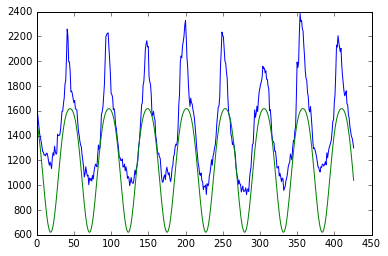

In [12]:
# plot time series of some random point
lon =180; lat = 50
plt.plot(d_sea[:,lat,lon])
plt.plot(m[:,lat,lon])

In [13]:
ymin = min(Y.min(), X.min())
ymax = max(Y.max(), X.max())

def f(t):
    plt.imshow(d_sea[t,:,:], vmin=ymin, vmax=ymax, interpolation='nearest')
    plt.show()
    
def g(t):
    plt.imshow(y[t,:,:]*landmask, vmin=ymin, vmax=ymax, interpolation='nearest')
    plt.show()
    
def h(t):
    plt.imshow(m[t,:,:], vmin=ymin, vmax=ymax, interpolation='nearest')    

/home/mi/fab/opt/anaconda2/lib/python2.7/site-packages/scipy/io/netcdf.py:297: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


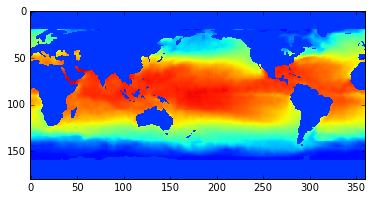

In [14]:
interact(f ,t= (0, T-1));

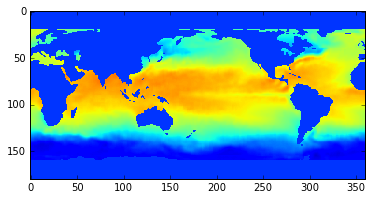

In [15]:
interact(g,t = (0, T-1));

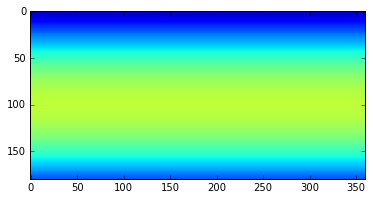

In [16]:
interact(h,t = (1, T-1));

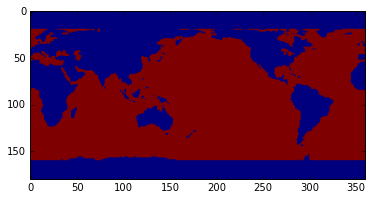

In [17]:
plt.imshow(landmask)